**ส่วนนี้คือการ load ข้อมูล และการกำจัด outliers (ท่านสามารถดูเพิ่มเติมได้ที่ 1_Data_Cleaning.ipynb)**

**ส่วนนี้ได้รวมการสร้าง dummy variables และการทำ data scaling (standardisation) ไว้ด้วย (ท่านสามารถดูเพิ่มเติมได้ที่ 3_Logit.ipynb)**

**สำหรับ Naïve Bayes จะเริ่มต่อท้ายหลังจบส่วนนี้**

In [1]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [2]:
# disable warnings that are not critical for a clean looking
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv('./dataset/Churn_Modelling.csv')

In [5]:
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)

#### การกำจัด outliers

In [6]:
def my_func(feature, upper, lower):
    tmp = df[(df[feature] >= upper) | (df[feature] <= lower)]
    df.drop(index=tmp.index, inplace=True)

In [7]:
my_func('CreditScore',None,383)
my_func('Age',62,None)

#### การสร้าง dummy variables

In [8]:
df_new = pd.get_dummies(df, drop_first=True)

#### ทำการแบ่งข้อมูล train/test ด้วยอัตราส่วน 80:20

In [9]:
X = df_new.drop('Exited', axis=1)
y = df_new['Exited']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

#### Data Scaling (Standardisation)

In [11]:
from sklearn.preprocessing import StandardScaler

sc_X_train = StandardScaler()
sc_X_test = StandardScaler()

In [12]:
tmp = X_train
std = sc_X_train.fit_transform(tmp)
X_train = pd.DataFrame(std, columns=tmp.columns)

tmp = X_test
std = sc_X_test.fit_transform(tmp)
X_test = pd.DataFrame(std, columns=tmp.columns)

#### เขียนฟังก์ชั่นสำหรับประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [14]:
acc = {}; f1 = {}; prec = {}; recl = {}

def my_eval(model,y_test,predicted):
    
    print(model,'Results')
    print('Accuracy: ', accuracy_score(y_test, predicted))
    print('F1 Score: ', f1_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('Recall: ', recall_score(y_test, predicted))
    
    acc[model] = accuracy_score(y_test, predicted)
    f1[model] = f1_score(y_test, predicted)
    prec[model] = precision_score(y_test, predicted)
    recl[model] = recall_score(y_test, predicted)
    
    # declair as a global model to ratain the evalutation values along the notebook
    global df_model_compare
    df_model_compare = pd.DataFrame.from_dict(
        [acc,f1,prec,recl]
    ).rename(
        index={0:'Accuracy',1:'F1 Score',2:'Precision',3:'Recall'}
    )
    #display(df_model_compare)

**Naïve Bayes จะเริ่มต้นขึ้นต่อจากนี้**

---

# Naïve Bayes

Naïve Bayes ใช้หลักการความน่าจะเป็นของ Bayes' theorem คือ dependent event (เหตุการณ์ก่อนหน้ามีผลต่อความน่าจะเป็นของเหตุการณ์หลัง) มาตัดสินเหตุการณ์ใหม่ที่จะเกิดขึ้น คือ Conditional Probability

Naïve Bayes พิจารณาจุดรอบ ๆ ตัวเหมือน KNN แต่ไม่ได้วัดระยะห่างระหว่างจุดเหมือน KNN สำหรับ Naïve Bayes จะวัดความน่าจะเป็นแทน

In [15]:
from sklearn.naive_bayes import GaussianNB

## การหาค่า var_smoothing ที่เหมาะสมที่สุด

ตามปกติ Gaussian Naïve Bayes จะให้น้ำหนักกับจุดข้อมูลที่อยู่ใกล้ค่าเฉลี่ยของการแจกแจงมากกว่า ซึ่งอาจจะไม่เหมาะสมหากลักษณะของชุดข้อมูลที่นำมาใช้ไม่ใกล้เคียงกับการแจกแจงแบบปกติ `var_smoothing` จึงเป็นค่าที่ใช้เพื่อคำนวณการขยายขอบเขต (หรือ smooth) ของการนับรวมจุดข้อมูลที่อยู่ไกลออกไปจากค่าเฉลี่ยของการแจกแจง

In [16]:
accuracy_lst = []
f1_lst = []
precision_lst = []
recall_lst = []

my_range = np.logspace(0,-3, num=100)

for i in my_range:
    nb= GaussianNB(var_smoothing=i)
    nb.fit(X_train, y_train)
    predicted_i = nb.predict(X_test)
    
    accuracy_lst.append(accuracy_score(y_test, predicted_i))
    f1_lst.append(f1_score(y_test, predicted_i))
    precision_lst.append(precision_score(y_test, predicted_i))
    recall_lst.append(recall_score(y_test, predicted_i))

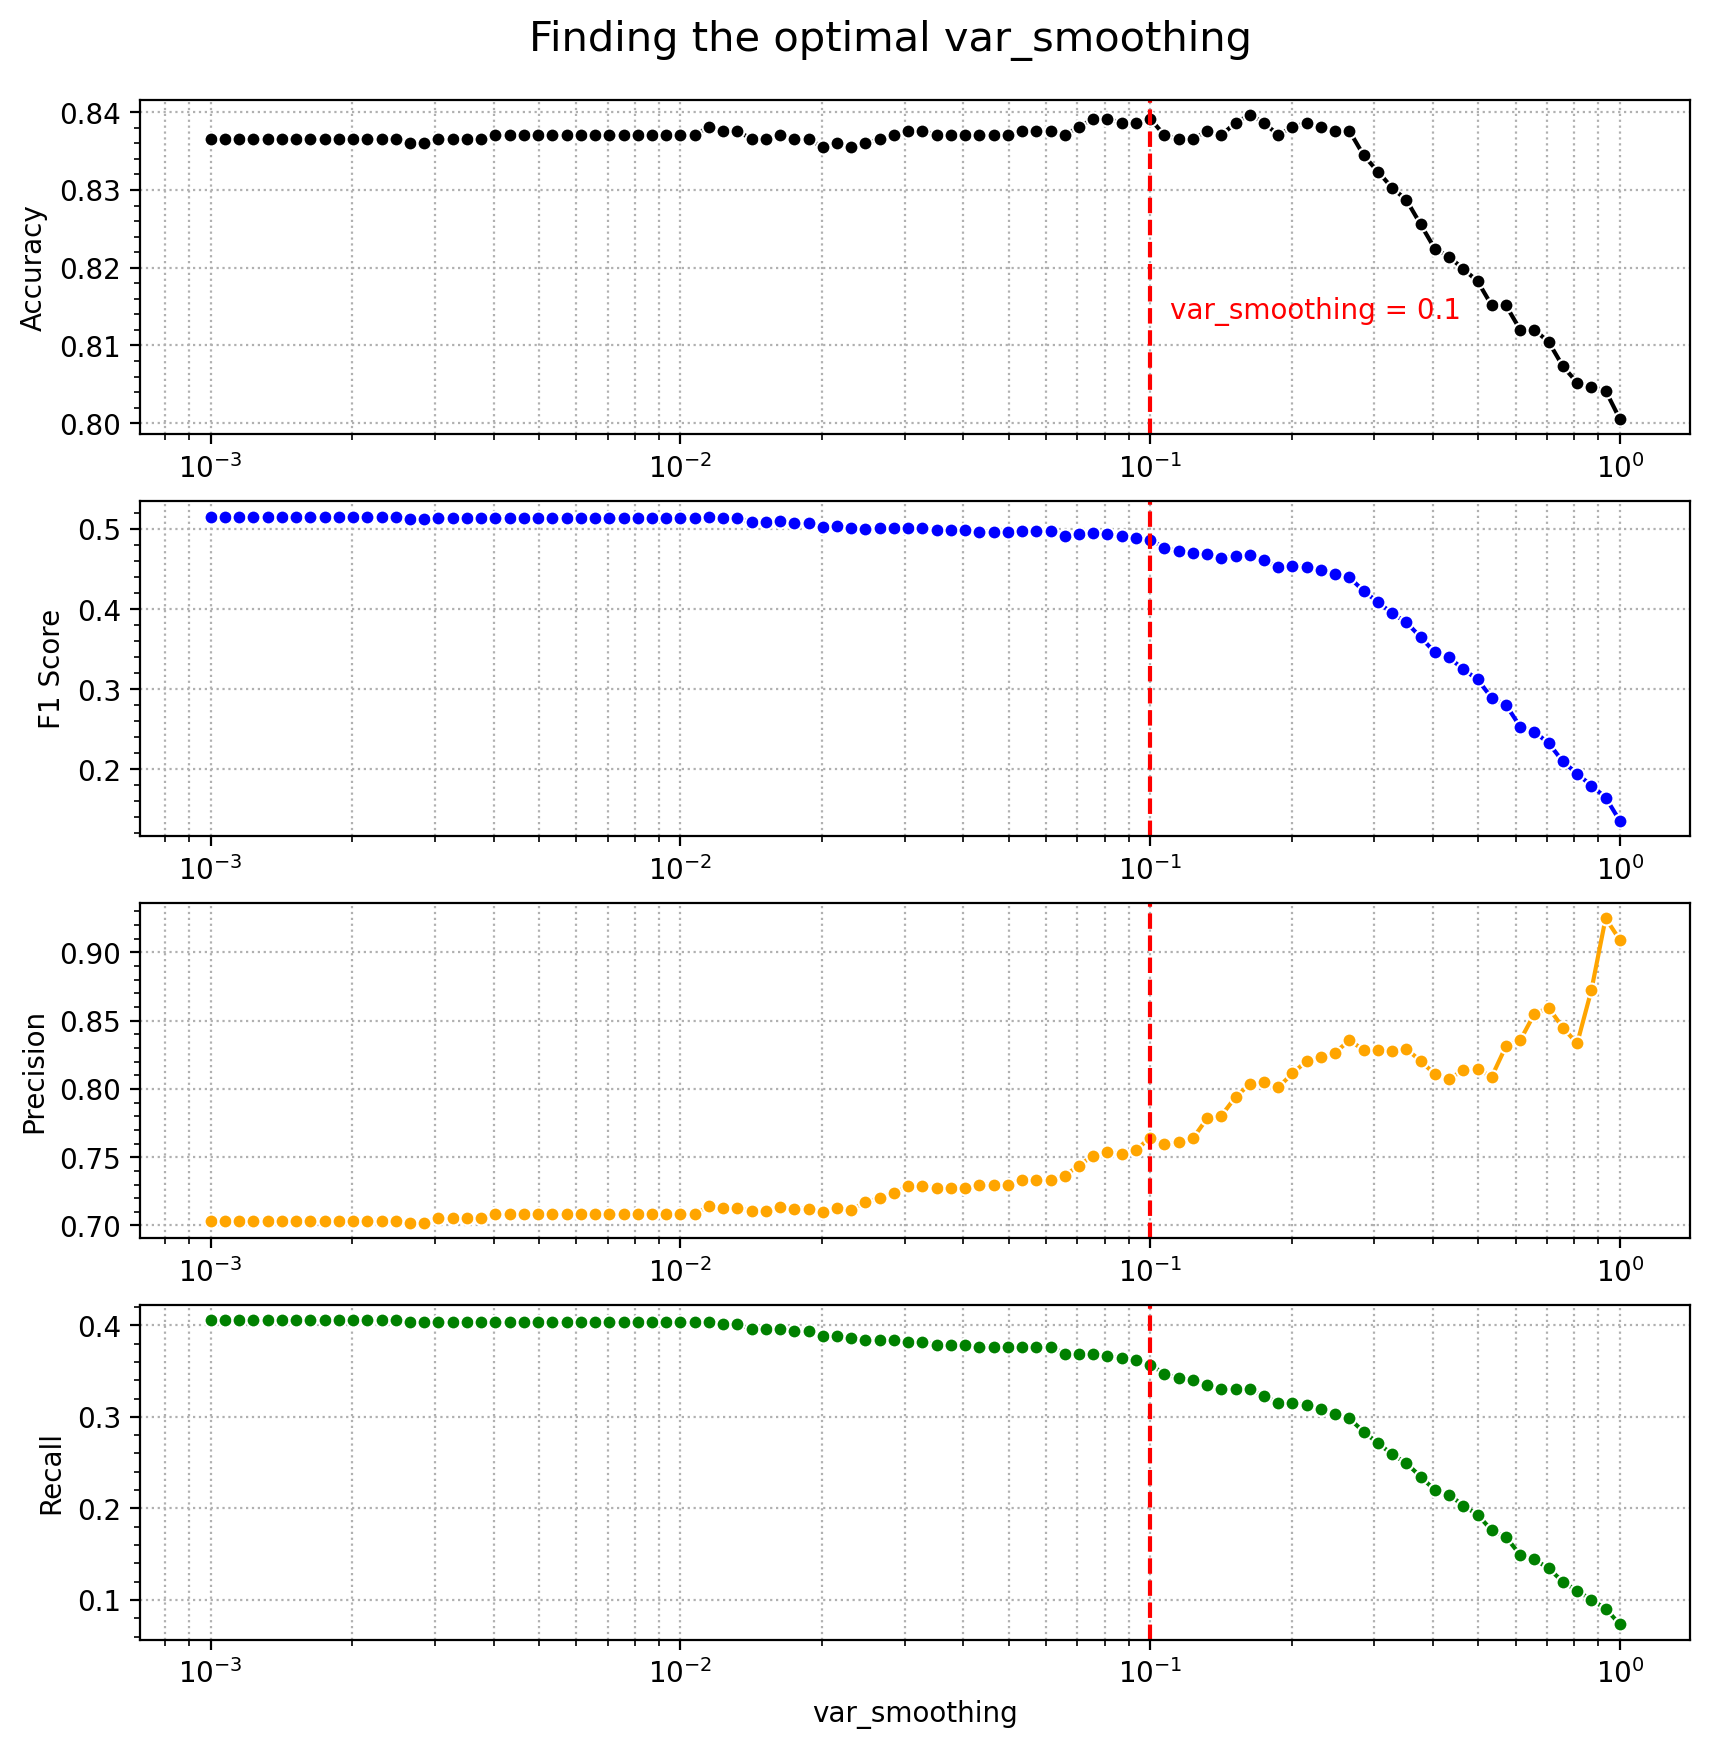

In [17]:
fig, ax = plt.subplots(4,1,figsize=(10,10))

# plot accuracy, f1 score, precision, recall
order = [0,1,2,3]
y = [accuracy_lst, f1_lst, precision_lst, recall_lst]
color = ['black', 'blue', 'orange', 'green']

for order_, y_, color_ in zip(order, y, color):
    sns.lineplot(x=my_range, y=y_,color=color_, linestyle='-',
                 marker='o', markersize=5, ax=ax[order_])

# annotate red lines which indicate the selected K
selected_var_smoothing = 0.1
for i in range(0,4):
    ax[i].minorticks_on()
    ax[i].grid(linestyle=':', axis='x', which='both')
    ax[i].grid(linestyle=':', axis='y', which='major')
    ax[i].set(xscale='log')
    ax[i].axvline(selected_var_smoothing,0,1, color='red', ls='--')

# annotate var_smoothing
plt.text(selected_var_smoothing+0.01, 1.5,
         f'var_smoothing = {selected_var_smoothing}',
         size=10, color='red')
    
ax[0].set(ylabel='Accuracy')
ax[1].set(ylabel='F1 Score')
ax[2].set(ylabel='Precision')
ax[3].set(ylabel='Recall', xlabel='var_smoothing')

fig.suptitle('Finding the optimal var_smoothing', fontsize=15, y=0.92)
plt.tight_layout()

สำหรับ dataset นี้:
- Recall สำคัญกว่า Precision เพราะ Recall พิจารณา False Negative
    - Recall คือ จำนวนที่ทำนายถูกว่า churn จากความจริงที่เป็น churn ทั้งหมด
    - False Negative สำคัญ เพราะทำนายว่า non-churn แต่ความจริงคือ churn
        - ทำนายผิดแบบนี้ ธนาคารจะไม่มีมาตรการรักษาหรือดึงดูดลูกค้าคนนี้จนเขาเลิกใช้ธนาคาร (churn) ได้
    - ต้องพยายามทำให้ False Negative ต่ำ ๆ และ True Positive สูง ๆ

แต่ในขณะเดียวกัน:
- Precision ก็สำคัญ เพราะ Precision พิจารณา False Positive
    - Precision คือ จำนวนที่ทายถูกว่า churn จากจำนวนที่ทายว่า churn ทั้งหมด
    - False Positive คือทำนายว่า churn แต่ความจริงคือ non-churn
        - ทำนายผิดแบบนี้ จะทำให้ธนาคารสูญเสียทรัพยากรไปกับมาตรการรักษาหรือดึงดูดลูกค้าที่เขาไม่ได้จะเลิกใช้ธนาคาร และยังอาจทำให้ลูกค้ารู้สึกรำคาญโดยไม่จำเป็นอีกด้วย

จึงเลือกค่า **var_smoothing=0.27** (เพราะไม่ได้เน้นที่ Recall อย่างเดียว แต่ให้ความสำคัญกับ Precision ด้วย และเมื่อพิจารณา F1 Score (ค่า balance ของ Precision กับ Recall ) ก็ยังให้ค่าที่สูงเมื่อเทียบกับที่ค่า K อื่น ๆ)

สร้าง (ฝึกสอน) model:

In [18]:
nb = GaussianNB(var_smoothing=0.1)

In [19]:
nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.1)

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [20]:
# Save Model
joblib.dump(nb, './models/NB.pkl')

# Load Model
#nb = joblib.load('./models/NB.pkl')

['./models/NB.pkl']

## การประเมิน model ที่ใช้ทำนาย

ใช้โมเดลทำนาย test set:

In [21]:
nb_predicted = nb.predict(X_test)

In [22]:
confusion_matrix(y_test, nb_predicted)

array([[1461,   45],
       [ 263,  146]], dtype=int64)

[ TN FP ]  
[ FN TP ]

TP (ทำนายว่า churn; ความจริงคือ churn)  
TN (ทำนายว่า non-churn; ความจริงคือ non-churn)  
FP (ทำนายว่า churn; ความจริงคือ non-churn)  
FN (ทำนายว่า non-churn; ความจริงคือ churn)

Churn = เลิกใช้ธนาคาร  
Non-churn = ไม่เลิกใช้ธนาคาร

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [23]:
my_eval('NB',y_test,nb_predicted)

NB Results
Accuracy:  0.8391644908616188
F1 Score:  0.48666666666666664
Precision:  0.7643979057591623
Recall:  0.3569682151589242


---

บันทึกค่าประเมินประสิทธิภาพของแต่ละ model เพื่อใช้เปรียบเทียบใน notebook ชื่อ 9_Comparison.ipynb:

In [24]:
df_model_compare.to_csv('./eval_results/eval_results_NB.csv')